# Evaluating a Use of Regression Machine Learning Models for Predicting Morning RMSSD

RMSSD (Root Mean Square of the Successive Differences) is a commonly used measure of heart rate variability (HRV), which refers to the variation in the time interval between consecutive heartbeats. RMSSD is often used as an indicator of vagal tone, which is a measure of the activity of the parasympathetic nervous system, which regulates the body's "rest and digest" functions. Higher HRV is generally associated with good physical and mental health, while lower HRV can indicate stress, fatigue, or other health problems.

This notebook implements a machine learning model for predicting the next morning's rmssd value. The data was retrieved from the "Athlete Data Warehouse" PostgreSQL database, which integrates athletic activity and lifestyle information from various sources, and was exported into a CSV file included with this notebook. The data is loaded into pandas dataframe then preprocessed and transformed by converting dates to numeric values, shifting up certain columns to exclude the values that will be predicted, and selecting relevant features. 
The code defines a function, return_morn_rmssd, that takes in the preprocessed data and returns a prediction of the next morning's rmssd value. The prediction is made using a combination of regression models including RandomForrestRegressor, MLPRegressor and xgboost. The code also includes various error metrics to evaluate the performance of the model, such as mean squared error, mean absolute error, and mean absolute percentage error and plot the predicted vs measured values.

Import Libraries

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import datetime
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt

Define a function to return a prediction for the next morning rmssd value

In [16]:
def return_morn_rmssd(sql_data,suffer_score_values,days_past=None):

    predictions_array = []
    rmssd_data = sql_data.copy()

    #######################################
    #### PREPARE THE DATA ####
    #######################################

    #shift column up to drop the ema values that included rmssd that we are trying to predict
    rmssd_data['oura_sleep_rmssd_42d_ema'] = rmssd_data.oura_sleep_rmssd_42d_ema.shift(-3)
    rmssd_data['oura_sleep_rmssd_7d_ema'] = rmssd_data.oura_sleep_rmssd_7d_ema.shift(-3)
    #shift column up to include a value from yesterday
    rmssd_data['wellness_total_steps'] = rmssd_data.wellness_total_steps.shift(-1)
    rmssd_data['gc_well_evn_stress_3d_ema'] = rmssd_data.gc_well_evn_stress_3d_ema.shift(-1)
    rmssd_data['nutr_daily_fiber_3d_ema'] = rmssd_data.nutr_daily_fiber_3d_ema.shift(-1)

    #convert date to numeric
    rmssd_data['local_date'] = pd.to_datetime(rmssd_data['local_date'])
    rmssd_data['local_date'] = rmssd_data['local_date'].map(datetime.datetime.toordinal)
    #sort by date
    rmssd_data = rmssd_data.sort_values(by=['local_date'])
    
    # Select features to include in the train/predict datasets. Last feature is the one that we are predicting ('oura_sleep_rmssd').
    rmssd_data = rmssd_data[['local_date',
                        'gc_well_sleep_hr','gc_well_morning_hr',
                        'oura_sleep_rem_yest','oura_sleep_deep_yest','oura_sleep_temperature_deviation_yest','oura_sleep_awake_yest','oura_sleep_light_yest',
                        'oura_sleep_rmssd_42d_ema','oura_sleep_rmssd_7d_ema',
                        'act_pmc_ctl','act_pmc_atl',
                        'act_last_alt_ema',
                        'wellness_total_steps','gc_well_evn_stress_3d_ema',
                        'nutr_daily_fiber_3d_ema',
                        'weight_gm','body_water',
                        'act_last_alt','act_last_long','act_daily_suffer_score',
                        'weather_avg_dew_point','weather_avg_temperature','weather_stddev_air_pressure','weather_avg_air_pressure','weather_avg_wind_direction',
                        'oura_sleep_rmssd_3d_ema'
                        ]]
    # Create the array to store ATL,CTL and TSS values
    atl_ctl_values = []
    # Put data into 'atl_ctl_values' array
    if days_past is not None:
        rmssd_data = rmssd_data.iloc[:days_past] # Adjust how many lines you would like to drop (-2 two days back, predicting for the day before yesterday)
        actual_oura_sleep_rmssd = int(rmssd_data['oura_sleep_rmssd_3d_ema'].iat[-1])
        today_atl = rmssd_data['act_pmc_atl'].iat[-1]
        today_ctl = rmssd_data['act_pmc_ctl'].iat[-1]
        suffer_score_value = rmssd_data['act_daily_suffer_score'].iat[-1]
        atl_ctl_values.append([suffer_score_value,today_atl,today_ctl])
    else: 
        actual_oura_sleep_rmssd = None
        # Calculate ATL from suffer score (Coggan formula -- 'CTLtoday = CTLyesterday + (TSStoday - CTLyesterday)*(alpha)')
        for suffer_score_value in suffer_score_values:
            yesterday_atl = rmssd_data['act_pmc_atl'].iat[-2]
            yesterday_ctl = rmssd_data['act_pmc_ctl'].iat[-2]
            today_atl = yesterday_atl+(suffer_score_value-yesterday_atl)*0.1428 # alpha = 1/7
            today_ctl = yesterday_ctl+(suffer_score_value-yesterday_ctl)*0.0238 # alpha = 1/42
            atl_ctl_values.append([suffer_score_value,today_atl,today_ctl])

    ##########################
    #### TRAIN THE MODEL #####
    ##########################
                
    # Select all rows except the last row, to create the dataset to train the model on.
    data_train = rmssd_data.iloc[:-1 , :]
    data_train = data_train.dropna()

    # Convert train df to numpy array
    train_data_np = np.array(data_train)

    # Shuffle the train np array
    np.random.shuffle(train_data_np)

    x_train = train_data_np[:, :-1] # all but last column
    y_train = train_data_np[:, -1] # last column 

    # SCALE THE TRAIN DATA
    # https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
    #sc = StandardScaler()
    sc = MinMaxScaler()  
    scaler = sc.fit(x_train)
    # Scale training dataset
    x_train = scaler.transform(x_train) 

    # CREATE AND TRAIN THE MODEL
    # MLP Regressor model
    mlp_model = MLPRegressor(hidden_layer_sizes=(50,25,10),max_iter = 3000, activation='relu',solver='adam',alpha=10,learning_rate='adaptive',random_state=8)
    mlp_reg_mod = mlp_model.fit(x_train, y_train) 

    # Random Forest model
    rf_model = ensemble.RandomForestRegressor(n_estimators=140,min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=140,bootstrap=False, random_state=8)
    rf_reg_mod = rf_model.fit(x_train, np.ravel(y_train,order='C'))

    # XGB Regressor Model
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.12,max_depth = None, alpha = 0.0001, n_estimators = 30)
    xgb_reg_mod = xgb_model.fit(x_train, np.ravel(y_train,order='C'))
    

    ##########################
    ######## PREDICT #########
    ##########################

    # Select the last row. To create the dataset for the current day that we will be predicting for.
    data_pred = rmssd_data.iloc[-1:]
    data_pred.drop('oura_sleep_rmssd_3d_ema', axis=1, inplace=True)
    # Prepare the data and run the prediction
    for atl_ctl_value in atl_ctl_values:
        tss = atl_ctl_value[0]
        atl = atl_ctl_value[1]
        ctl = atl_ctl_value[2]
        # Replace actual TSS value with a value from "atl_ctl_values" array
        data_pred['act_daily_suffer_score'] = tss
        # Replace actual ATL value with a value from "atl_ctl_values" array
        data_pred['act_pmc_atl'] = atl
        # Replace actual CTL value with a value from "atl_ctl_values" array
        data_pred['act_pmc_ctl'] = ctl

        # Convert prediction df to numpy array
        pred_data_np = np.array(data_pred)
        # Replace NaN values with 0
        pred_data_np = np.where(np.isnan(pred_data_np), 0, pred_data_np)

        # SCALE THE PREDICTION DATA
        # Scale prediction dataset
        pred_data_np = scaler.transform(pred_data_np)

        # MAKE A PREDICTION
        # Random Forrest regressor model 
        mod_predict = rf_reg_mod.predict(pred_data_np)
        #Append prediction and the coresponding evn stress value to predictions array
        predictions_array.append([int(mod_predict),tss,int(atl),int(ctl),actual_oura_sleep_rmssd])

    for prediction in predictions_array:
        print('The model predicted that todays Suffer Score of {} will result in ATL of {} causing morning RMSSD (3d EMA) to be: {}. The actual morning RMSSD was: {}'.format(prediction[1],prediction[2],prediction[0],prediction[4]))

    return(predictions_array)

Define Functio to Evaliuate Predictions

In [17]:
def evaluate(y_test,predictions):
        mape = mean_absolute_percentage_error(y_test,predictions)*100
        accuracy = 100 - mape
        return mape,accuracy

Set Variables:
How many days of data to use for the model to predict (-120 to evaluate the model on 120 most recent days).These are excluded from training set.
If "None", the model will be trained on all available data, and make a prediction for tomorrows RMMSD evaluating for each value from a range of TSS values ("suffer_score_values" array).

In [18]:
days_past = -120
suffer_score_values = [0,20,40,60,80,100,150,200,300]
predictions = []
predicted_rmssd = []
actual_rmssd = []

Load data from CSV into pandas dataframe.

In [19]:
sql_data = pd.read_csv("RMSSD_Data_All.csv")

Call "return_morning_rmssd", evaluate the accuracy of the returned prediction and plot the results.

The model predicted that todays Suffer Score of 80 will result in ATL of 63 causing morning RMSSD (3d EMA) to be: 48. The actual morning RMSSD was: 44
The model predicted that todays Suffer Score of 0 will result in ATL of 54 causing morning RMSSD (3d EMA) to be: 47. The actual morning RMSSD was: 38
The model predicted that todays Suffer Score of 112 will result in ATL of 62 causing morning RMSSD (3d EMA) to be: 43. The actual morning RMSSD was: 44
The model predicted that todays Suffer Score of 70 will result in ATL of 63 causing morning RMSSD (3d EMA) to be: 52. The actual morning RMSSD was: 44
The model predicted that todays Suffer Score of 84 will result in ATL of 66 causing morning RMSSD (3d EMA) to be: 43. The actual morning RMSSD was: 38
The model predicted that todays Suffer Score of 0 will result in ATL of 57 causing morning RMSSD (3d EMA) to be: 41. The actual morning RMSSD was: 42
The model predicted that todays Suffer Score of 53 will result in ATL of 56 causing morning RMS

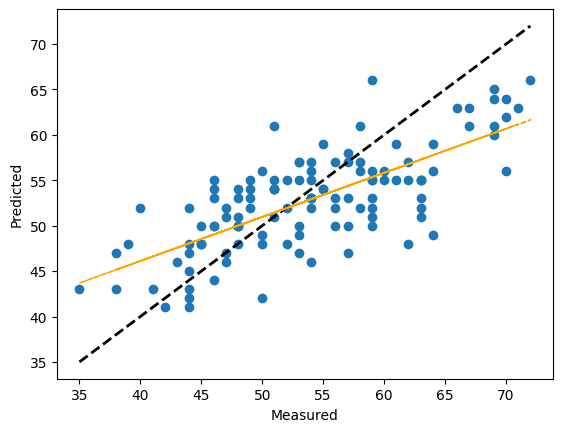

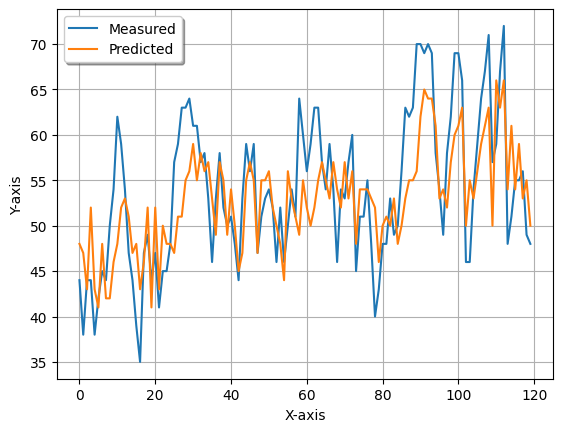

In [20]:
if days_past is not None:
    sql_data = sql_data[sql_data['oura_sleep_rmssd'].notna()]
    for day in range(days_past,0):
        predictions.append(return_morn_rmssd(sql_data,suffer_score_values,day))

    for prediction in predictions:
        predicted_rmssd.append(prediction[0][0])
        actual_rmssd.append(prediction[0][4])
    # Evaluate the model's accuracy
    mod_mse = mean_squared_error(actual_rmssd, predicted_rmssd)
    mod_rmse = np.sqrt(mod_mse)
    mod_mape =  evaluate(actual_rmssd, predicted_rmssd)[0]
    # Calculate correlation between actual and predicted RMSSD
    corr, _ = pearsonr(actual_rmssd, predicted_rmssd)
    # Print the results
    print('Model Correlation: {}'.format(corr))
    print('Model RMSE: {}'.format(mod_rmse))
    print('Model MAPE: {}%'.format(mod_mape))

    ### PLOTS ###
    # Plot the predicted vs measured on a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(actual_rmssd, predicted_rmssd)
    ax.plot([min(actual_rmssd), max(actual_rmssd)], [min(actual_rmssd), max(actual_rmssd)], 'k--', lw=2)
    #compute and plot the line of best fit predicted_rmssd
    z = np.polyfit(actual_rmssd, predicted_rmssd, 1)
    p = np.poly1d(z)
    plt.plot(actual_rmssd,p(actual_rmssd),linewidth=1, linestyle="--")
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    # Plot the predicted vs measured on a Line Plot
    x_ax = range(len(actual_rmssd))
    plt.plot(x_ax, actual_rmssd, label="Measured")
    plt.plot(x_ax, predicted_rmssd, label="Predicted")
    plt.xlabel('Timeline (Days)')
    plt.ylabel('RMSSD')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

else:
    return_morn_rmssd(sql_data,suffer_score_values,days_past)
    sql_data = sql_data[sql_data['oura_sleep_rmssd'].notna()]
    current_rmssd_baseline = round(sql_data['oura_sleep_rmssd_baseline'].iat[1],3)
    oura_rmssd_3d_ema_std = round(sql_data['oura_sleep_rmssd_3d_ema'].std(),3)
    print('Current RMSSD Baseline: {}'.format(current_rmssd_baseline))
    print('Oura RMSSD Standard Deviation: {}'.format(oura_rmssd_3d_ema_std))